In [51]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
import os
os.listdir('../data/')

['TSLA_news.csv', 'reddit_wsb.csv', 'TSLA.csv']

In [77]:
#Importing the data
tsla_data = pd.read_csv('../data/TSLA_news.csv')
tsla_data.drop(columns=['Unnamed: 0'], inplace=True)
#transform column to date without time
tsla_data['created'] = pd.to_datetime(tsla_data.dt).dt.date
tsla_data.drop(columns=['dt'], inplace=True)
tsla_data=tsla_data.drop_duplicates()

In [78]:
#Checking the first 5 rows of the data
tsla_data.head()


,title,created
0,Lucid Group Stock Looks More Vulnerable Than T...,2022-06-27
1,Better Buy : Tesla vs . Rivian | The Motley Fool,2022-06-27
2,"Tesla , Rivian and Nio stock price targets cut...",2022-06-27
3,"Why Tesla Shares Rose Today , but Nio and Luci...",2022-06-27
5,"Tesla Inc . stock falls Monday , still outperf...",2022-06-27


In [79]:
#Get information about the data
tsla_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5300 entries, 0 to 5732
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5300 non-null   object
 1   created  5300 non-null   object
dtypes: object(2)
memory usage: 124.2+ KB


In [80]:
#cleaning the data and getting the sentiment score
import re
def clean_text(text):
    text = str(text).lower()
    #replace nan values with empty string
    text = text.replace('nan', '')
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')  
    text=text.replace('\xa0',' ')
    #remove https links
    text = re.sub(r'http\S+', '', text)
    return text
#function to define sentiment from reddit comments
from textblob import TextBlob
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

tsla_data['sentiment_score_v1']=tsla_data.title.apply(clean_text).apply(get_sentiment)

In [81]:
#Sentiment analysis for stock news title of Tesla using VADER
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

def analyze_sentiment(dataframe):
    # Download necessary NLTK data
    nltk.download('vader_lexicon', quiet=True)
    
    # Initialize the VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    
    # Define a function to get compound sentiment score
    def get_sentiment(text):
        return sia.polarity_scores(text)['compound']
    
    # Apply sentiment analysis to the 'title' column
    dataframe['sentiment_score_v2'] = dataframe['title'].apply(get_sentiment)
    
    # Categorize sentiment
    def categorize_sentiment(score):
        if score > 0.05:
            return 'Positive'
        elif score < -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    
    dataframe['sentiment_category'] = dataframe['sentiment_score_v2'].apply(categorize_sentiment)
    
    return dataframe

# Assuming you have a DataFrame named tsla_data
tsla_data = analyze_sentiment(tsla_data)

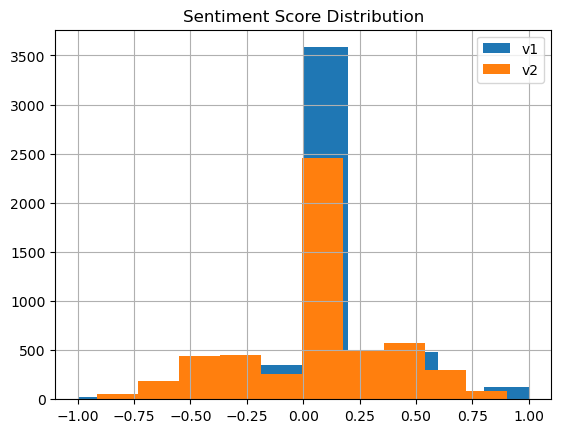

In [82]:
tsla_data['sentiment_score_v1'].hist(label='v1')
tsla_data['sentiment_score_v2'].hist(label='v2')
plt.legend()
plt.title('Sentiment Score Distribution')
plt.show()

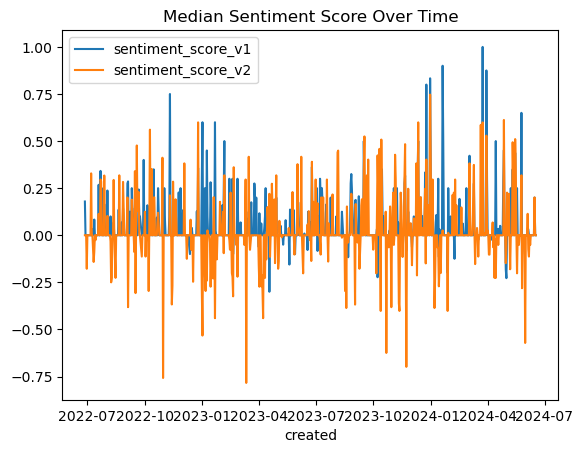

In [83]:
#plotting the sentiment score over time
tsla_data.groupby('created').sentiment_score_v1.median().plot()
tsla_data.groupby('created').sentiment_score_v2.median().plot()
plt.legend()
plt.title('Median Sentiment Score Over Time')
plt.show()

In [84]:
#import TESt stock data
tsla_stock = pd.read_csv('../data/TSLA.csv')
tsla_stock['created']=pd.to_datetime(tsla_stock['Unnamed: 0']).dt.date

In [85]:
tsla_data.groupby('created')[['sentiment_score_v1', 'sentiment_score_v2']].median()

,sentiment_score_v1,sentiment_score_v2
created,,
2022-06-27,0.179167,0.00000
2022-06-28,0.000000,0.00000
2022-06-29,0.000000,0.00000
2022-06-30,0.000000,-0.17790
2022-07-01,0.000000,0.00000
...,...,...
2024-06-13,0.000000,0.00000
2024-06-14,0.000000,0.00000
2024-06-15,0.200000,0.20095


In [86]:
#merge the stock data with the news average sentiment score
tsla_stock_data = tsla_stock.merge(tsla_data.groupby('created')[['sentiment_score_v1', 'sentiment_score_v2']].median(), on='created', how='left')
tsla_stock_data

,Unnamed: 0,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA,created,sentiment_score_v1,sentiment_score_v2
0,2022-06-27,249.366669,252.070007,242.566666,244.919998,89178300,0.0,0.0,239.76,2022-06-27,0.179167,0.0000
1,2022-06-28,244.483337,249.970001,232.343338,232.663330,90391200,0.0,0.0,238.89,2022-06-28,0.000000,0.0000
2,2022-06-29,230.500000,231.173340,222.273331,228.490005,82897200,0.0,0.0,237.37,2022-06-29,0.000000,0.0000
3,2022-06-30,224.509995,229.456665,218.863327,224.473328,94600500,0.0,0.0,235.25,2022-06-30,0.000000,-0.1779
4,2022-07-01,227.000000,230.229996,222.119995,227.263336,74460300,0.0,0.0,231.56,2022-07-01,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
492,2024-06-11,173.919998,174.750000,167.410004,170.660004,64761900,0.0,0.0,174.97,2024-06-11,0.000000,0.0000
493,2024-06-12,171.119995,180.550003,169.800003,177.289993,90389400,0.0,0.0,175.43,2024-06-12,0.000000,0.0000
494,2024-06-13,188.389999,191.080002,181.229996,182.470001,118984100,0.0,0.0,176.34,2024-06-13,0.000000,0.0000
495,2024-06-14,185.800003,186.000000,176.919998,178.009995,81361700,0.0,0.0,176.44,2024-06-14,0.000000,0.0000


### Correlation between prie change and sentiment score

In [87]:
#calculate the correlation between the sentiment score and the stock price
tsla_stock_data['Close_diff'] = tsla_stock_data['Close'].diff()#.shift(-1)
tsla_stock_data[['Close_diff', 'sentiment_score_v1']].corr()

,Close_diff,sentiment_score_v1
Close_diff,1.000000,0.036126
sentiment_score_v1,0.036126,1.000000


In [88]:
tsla_stock_data[['Close_diff', 'sentiment_score_v2']].corr()

,Close_diff,sentiment_score_v2
Close_diff,1.000000,0.127405
sentiment_score_v2,0.127405,1.000000
